# n-step algorithms and eligibility traces

For some applications it makes sense to look several steps ahead before making a choice. In the grid example, if the agent can see that the current trajectory is leading the agent to fall off the cliff, the agent can take avoiding action now, before it becomes too late. In a sense, the agent is looking further into the future.

Why not have a two-step lookahead? Or more? That is precisely what -step algorithms are all about. They provide a generalization of unrolling the expected value estimate to any number of steps. This is beneficial because it bridges the gap between dynamic programming and Monte Carlo.

The essence of the idea is to extend one of the TD implementations to iterate over any number of future states. Recall that the lookahead functionality came from DP, which combined the current reward with the prediction of the next state.

“n-Step Algorithms” developed a method to provide the benefits of both bootstrapping and forward planning. An extension to this idea is to average over different values of n, an average of 2-step and 4-step SARSA, for example. You can take this idea to the extreme and average over all values of n.

Of course, iterating over different n-step updates adds a significant amount of computational complexity. Also, as you increase n the agent will have to wait for longer and longer before it can start updating the first time step. In the extreme this will be as bad as waiting until the end of the episode before the agent can make any updates (like MC methods).

The problem with the algorithms seen so far is that they attempt to look forward in time, which is impossible, so instead they delay updates and pretend like they are looking forward. One solution is to look backward in time, rather than forward. If you attempt to hike up a mountain in the fastest time possible, you can try several routes, then contemplate your actions to find the best trajectory.

In other words, the agent requires a new mechanism to mark a state-action pair as tainted so that it can come back and update that state with future updates. You can use *tracers* to mark the location of something of interest. Radioactive tracers help to diagnose illnesses and direct medicine. Geophysicists inject them into rock during hydraulic fracturing to provide evidence of the size and location of cracks. You can use a virtual tracer to remind the agent of which state-action estimates need updating in the future.

Next, you need to update state-action function with an average of all the n-step returns. A one-step update is the TD error update. You can approximate an average using an exponentially weighted moving average, which is the online equivalent of an average.

Combining the one-step update with the moving average, coupled with the idea of a tracer, provides an online SARSA that has zero delay (no direct n-step lookahead) but all the benefits of forward planning and bootstrapping.

In case you were wondering, the term *eligibility* comes from the idea that the tracer decides whether a specific state-action pair in the action-value function is eligible for an update. If the tracer for a pair has a nonzero value, then it will receive some proportion of the reward.

*Eligibility traces* provide a computationally efficient, controllable hyperparameter that smoothly varies the learning regime between TD and MC. But it does raise the problem of where to place this parameter. Researchers have not found a theoretical basis for the choice of λ but experience provides empirical rules of thumb. In tasks with many steps per episode it makes sense to update not only the current step, but all the steps that led to that point. Like bowling lane bumpers that guide the ball toward the pins, updating the action-value estimates based upon the previous trajectory helps guide the movement of future agents. In general then, for nontrivial tasks, it pays to use λ>0.

However, high values of λ mean that early state-action pairs receive updates even though it is unlikely they contributed to the current result. Consider the grid example with λ≐1, which makes it equivalent to an MC agent. The first step will always receive an update, because that is the single direction in which it can move. This means that no matter where the agent ends up, all of the actions in the first state will converge to roughly the same value, because they are all affected by any future movement. This prevents it from learning any viable policy. In nontrivial problems you should keep λ<1.

The one downside is the extra computational complexity. The traces require another buffer. You also need to iterate over all states and actions on each step to see if there is an eligible update for them. You can mitigate this issue by using a much smaller eligibility list, since the majority of state-action pairs will have a near-zero value. In general, the benefits outweigh the minor computational burden.

## Setup

In [ ]:
!pip install pygame==1.9.6 pandas==1.0.5 matplotlib==3.2.1
!pip install --upgrade git+git://github.com/david-abel/simple_rl.git@77c0d6b910efbe8bdd5f4f87337c5bc4aed0d79c

In [ ]:
import numpy as np
import pandas as pd
import sys
from collections import defaultdict
import json
import os

from simple_rl.agents import Agent, QLearningAgent
from simple_rl.agents import DoubleQAgent, DelayedQAgent
from simple_rl.tasks import GridWorldMDP
from simple_rl.run_experiments import run_single_agent_on_mdp
from simple_rl.abstraction import AbstractionWrapper
from simple_rl.utils import chart_utils

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
matplotlib.use("agg", force=True)

In [ ]:
%matplotlib inline

## n-Step SARSA Agent
simple_rl doesn’t come with an n-Step SARSA implementation so I must create one first. The code is below. Again, most of the complexity is due to the library abstractions. The most important code is in the update function.

In [ ]:
class nStepSARSAAgent(QLearningAgent):
    def __init__(self, actions, n, name="n-Step SARSA",
                 alpha=0.1, gamma=0.99, epsilon=0.1, explore="uniform", anneal=False):
        self.T = sys.maxsize
        self.stored_rewards = []
        self.stored_states = []
        self.stored_actions = []
        self.n = n
        QLearningAgent.__init__(
            self,
            actions=list(actions),
            name=name,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            explore=explore,
            anneal=anneal)

    def policy(self, state):
        return self.get_max_q_action(state)

    def act(self, state, reward, learning=True):
        action = self.update(reward, state)
        return action

    def update(self, rt1, st1):
        if len(self.stored_states) == 0:
            action = self.epsilon_greedy_q_policy(st1)
            self.stored_actions.append(action)
            self.stored_states.append(st1)
            self.stored_rewards.append(rt1)
            return action

        if self.step_number < self.T:
            # Observe and store the next reward R_{t+1} and next state
            # S_{t+1}
            self.stored_rewards.append(rt1)
            self.stored_states.append(st1)

            # if s_{t+1} terminal
            if st1.is_terminal():
                self.T = self.step_number + 1
            else:
                action = self.epsilon_greedy_q_policy(st1)
                self.stored_actions.append(action)

        self.tau = self.step_number - self.n + 1
        if self.tau >= 0:
            # G = sum(\gamma * R)
            start_index = self.tau + 1
            end_index = min(self.tau + self.n, self.T)
            G = 0
            for i in range(
                    start_index, end_index + 1):  # Because range is exclusive
                G += self.gamma**(i - self.tau - 1) * self.stored_rewards[i]

            if self.tau + self.n < self.T:
                G += self.gamma**self.n * \
                    self.q_func[self.stored_states[(
                        self.tau + self.n)]][self.stored_actions[(self.tau + self.n)]]
            s_tau = self.stored_states[self.tau]
            a_tau = self.stored_actions[self.tau]
            self.q_func[s_tau][a_tau] += self.alpha * \
                (G - self.q_func[s_tau][a_tau])
        # If at end repeat until tau == T - 1
        self.step_number += 1
        if self.step_number >= self.T and self.tau < self.T - 1:
            self.update(None, None)
        return self.stored_actions[-1]

    def end_of_episode(self):
        self.prev_state = None
        self.prev_action = None
        self.episode_number += 1
        self.T = sys.maxsize
        self.step_number = 0
        self.stored_rewards = []
        self.stored_states = []
        self.stored_actions = []

    def reset(self):
        self.prev_state = None
        self.prev_action = None
        self.step_number = 0

## Experiment
Similar to before, I run the agents on the CliffWorld inspired environment. First I setup the the global settings, instantite the environment, then I test the three algorithms and save the data.

In [ ]:
np.random.seed(42)
visualise_double_q_learning = False
visualise_delayed_q_learning = False

instances = 10
n_episodes = 500
alpha = 0.1
epsilon = 0.1

# Setup MDP, Agents.
mdp = GridWorldMDP(
    width=10, height=4, init_loc=(1, 1), goal_locs=[(10, 1)],
    lava_locs=[(x, 1) for x in range(2, 10)], is_lava_terminal=True, gamma=1.0, walls=[], slip_prob=0.0, step_cost=1.0, lava_cost=100.0)

print("SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = nStepSARSAAgent(
        mdp.get_actions(),
        n=1,
        epsilon=epsilon,
        alpha=alpha)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("sarsa_cliff_rewards.json")

print("2-Step SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = nStepSARSAAgent(
        mdp.get_actions(),
        n=2,
        epsilon=epsilon,
        alpha=alpha)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("2_step_sarsa_cliff_rewards.json")

print("4-Step SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = nStepSARSAAgent(
        mdp.get_actions(),
        n=4,
        epsilon=epsilon,
        alpha=alpha)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("4_step_sarsa_cliff_rewards.json")

SARSA
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.
2-Step SARSA
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.
4-Step SARSA
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.


## Results

Below is the code to visualise the training of the three agents. There are a maximum of 100 steps, over 500 episodes, averaged over 10 repeats. Feel free to tinker with those settings.

The results show the differences between the three algorithms. In general, a higher value of n learns more quickly, with diminishing returns.

In [ ]:
data_files = [("SARSA", "sarsa_cliff_rewards.json"),
              ("2-Step SARSA", "2_step_sarsa_cliff_rewards.json"),
              ("4-Step SARSA", "4_step_sarsa_cliff_rewards.json")]
fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            linewidth=1,
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()

## Eligibility Traces SARSA Agent

Eligibility traces implement n-Step methods on a sliding scale. They smoothly vary the amount that the return is projected, from a single step up to far into the future. They are implemented with “tracers” which remember where the agent has been in the past and update them accordingly. They are intuitive, especially in a discrete setting.

simple_rl doesn’t come with an Eligibility Traces SARSA implementation so I must create one first. The code is below. Again, most of the complexity is due to the library abstractions. The most important code is in the update function.

In [ ]:
class lambdaSARSAAgent(QLearningAgent):
    def __init__(self, actions, name="lambda SARSA",
                 alpha=0.5, lam=0.5, gamma=1.0, epsilon=0.1, explore="uniform",
                 anneal=False, replacement_method="accumulate"):
        self.lam = lam
        self.eligibility = defaultdict(lambda: defaultdict(lambda: 0))
        self.replacement_method = replacement_method
        QLearningAgent.__init__(
            self,
            actions=list(actions),
            name=name,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            explore=explore,
            anneal=anneal)

    def act(self, new_state, reward, learning=True):
        next_action = self.epsilon_greedy_q_policy(new_state)
        if self.prev_state is None:
            self.prev_state = new_state
            self.prev_action = next_action
            return next_action
        self.update(
            self.prev_state,
            self.prev_action,
            reward,
            new_state,
            next_action)
        self.prev_state = new_state
        self.prev_action = next_action
        return next_action

    def update(self, state, action, reward, next_state, next_action):
        td_error = reward + self.gamma * \
            self.q_func[next_state][next_action] - self.q_func[state][action]
        if self.replacement_method == "accumulate":
            self.eligibility[state][action] += 1
        elif self.replacement_method == "replace":
            self.eligibility[state][action] = 1
        for s in self.eligibility.keys():
            for a in self.eligibility[s].keys():
                self.q_func[s][a] += self.alpha * \
                    td_error * self.eligibility[s][a]
                self.eligibility[s][a] *= self.gamma * self.lam

    def end_of_episode(self):
        self.eligibility = defaultdict(lambda: defaultdict(lambda: 0))
        QLearningAgent.end_of_episode(self)


class lambdaWatkinsSARSAAgent(lambdaSARSAAgent):
    def epsilon_greedy_q_policy(self, state):
        # Policy: Epsilon of the time explore, otherwise, greedyQ.
        if np.random.random() > self.epsilon:
            # Exploit.
            action = self.get_max_q_action(state)
        else:
            # Explore
            action = np.random.choice(self.actions)
            # Reset eligibility trace
            self.eligibility = defaultdict(lambda: defaultdict(lambda: 0))
        return action

## Experiment
Similar to before, I run the agents on the CliffWorld inspired environment. First I setup the the global settings, instantite the environment, then I test the three algorithms and save the data.

In [ ]:
np.random.seed(42)
instances = 10
n_episodes = 500
alpha = 0.1
epsilon = 0.1

# Setup MDP, Agents.
mdp = GridWorldMDP(
    width=10, height=4, init_loc=(1, 1), goal_locs=[(10, 1)],
    lava_locs=[(x, 1) for x in range(2, 10)], is_lava_terminal=True, gamma=1.0, walls=[], slip_prob=0.0, step_cost=1.0, lava_cost=100.0)

print("lambda SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = lambdaSARSAAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha,
        lam=0.5)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("lambda_sarsa_0.5_cliff_rewards.json")

print("lambda SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = lambdaSARSAAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha,
        lam=0.8)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("lambda_sarsa_0.8_cliff_rewards.json")

lambda SARSA
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.
lambda SARSA
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.


## Results
Below is the code to visualise the training of the three agents. There are a maximum of 100 steps, over 500 episodes, averaged over 10 repeats. Feel free to tinker with those settings.

The results show the differences between two values for the lambda hyperparameter. Feel free to alter the value to see what happens. Also compare these results to the experiments with SARSA and n-Step agents. Try copying the code from that notebook into here and plotting the result.

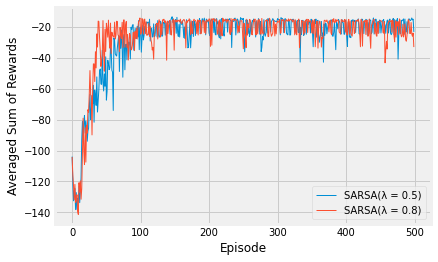

In [ ]:
data_files = [("SARSA(λ = 0.5)", "lambda_sarsa_0.5_cliff_rewards.json"),
              ("SARSA(λ = 0.8)", "lambda_sarsa_0.8_cliff_rewards.json"),
              ]
fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            linewidth=1,
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()